In [ ]:
# Import required libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from collections import Counter
import sys

# Import scikit-learn modules for Random Forest classification and evaluation

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.metrics import (f1_score, precision_score, recall_score,
                             accuracy_score, classification_report,
                             roc_curve, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, RocCurveDisplay)

### 1. LIBRARY VERSION TRACKING
- Create a comprehensive table of all library versions used in the project
- This ensures reproducibility by documenting exact package versions

In [ ]:


import matplotlib
import sklearn

versions_data = {
    'Library': [
        'Python',
        'pandas',
        'numpy', 
        'matplotlib',
        'scikit-learn',
        'math',
        'collections'
    ],
    'Version': [
        sys.version.split()[0],
        pd.__version__,
        np.__version__,
        matplotlib.__version__,
        sklearn.__version__,
        'Python built-in',
        'Python built-in'
    ],
    'Purpose': [
        'Programming language',
        'Data manipulation and analysis',
        'Numerical computations',
        'Data visualization',
        'Machine learning algorithms',
        'Mathematical functions (sqrt)',
        'Container datatypes (Counter - imported but not used)'
    ]
}

# Create DataFrame for better display
versions_df = pd.DataFrame(versions_data)

# Create markdown table format for easy inclusion in reports/documentation
print("MARKDOWN TABLE FORMAT:\n")
print("| Library | Version | Purpose |")
print("|---------|---------|---------|")
for _, row in versions_df.iterrows():
    print(f"| {row['Library']} | {row['Version']} | {row['Purpose']} |")

MARKDOWN TABLE FORMAT:

| Library | Version | Purpose |
|---------|---------|---------|
| Python | 3.12.2 | Programming language |
| pandas | 2.3.1 | Data manipulation and analysis |
| numpy | 2.3.2 | Numerical computations |
| matplotlib | 3.10.3 | Data visualization |
| scikit-learn | 1.7.1 | Machine learning algorithms |
| math | Python built-in | Mathematical functions (sqrt) |
| collections | Python built-in | Container datatypes (Counter - imported but not used) |


### 1.1 INITIAL CONFIGURATION (Before Training)
- Define all experimental settings that will be used in the Random Forest model
- This configuration captures the experimental design for reproducibility

In [9]:

# Data provenance settings object
rf_settings = {
    # Data configuration - file path and target variable settings
    'data_path': "./data/studentdras.csv",
    'target_column': 'Target',
    'test_size': 0.2,  # 20% of data for testing
    'shuffle': True,    # Randomly shuffle data before splitting
    'random_state': 42, # For reproducible results
    
    # Model hyperparameters for Random Forest tuning
    'n_trees_options': [400, 600, 800],  # Number of trees to try
    'max_depth_multipliers': [0.5, 1.0, 2.0],  # Multipliers for sqrt(n_features) to set max_depth
    'oob_score': True,  # Calculate out-of-bag score for model validation
    
    # Cross-validation settings
    'cv_folds': 3,  # Number of folds for cross-validation
    
    # Evaluation metrics configuration
    'f1_average': 'macro',  # Use macro averaging for multi-class F1 score
    'confusion_matrix_labels': ["Dropout(0)", "Enrolled(1)", "Graduate(2)"],  # Class labels for visualization
    
    # Visualization settings for plots
    'confusion_matrix_figsize': (5, 5),
    'feature_importance_figsize': (12, 9),
    'confusion_matrix_cmap': 'Blues',  # Color map for confusion matrix
    'grid_visible': False  # Whether to show grid in plots
}


In [10]:
# Load the dataset using the configured path
students = rf_settings['data_path']
students_df = pd.read_csv(students)

# Display first few rows to inspect the data structure
students_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [11]:
# Prepare features (X) by removing the target column
X_data = students_df.drop(rf_settings['target_column'], axis=1)

# Extract target variable (y) for classification
y_data = students_df[rf_settings['target_column']]

# Split data into training and testing sets
# This ensures we have separate data for training and evaluating the model
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=rf_settings['test_size'], shuffle=rf_settings['shuffle'])

# Print dataset shapes to verify the split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3539, 36)
(885, 36)
(3539,)
(885,)


In [12]:
# Hyperparameter tuning: Test different combinations of number of trees and max depth
n_trees = rf_settings['n_trees_options']
sqrt_n_features = sqrt(X_train.shape[1])  # Calculate sqrt of number of features
max_depths = [(int)(multiplier*sqrt_n_features) for multiplier in rf_settings['max_depth_multipliers']]  # Generate max_depth values

# Initialize variables to track the best model
best_model = None
best_oob = 0

# Grid search through all combinations of hyperparameters
for trees in n_trees:
    print("============================================")
    for depth in max_depths:
        # Create and train Random Forest with current hyperparameters
        clf = RandomForestClassifier(n_estimators=trees, max_depth=depth, random_state=rf_settings['random_state'], oob_score=rf_settings['oob_score'])
        clf.fit(X_train, y_train)
        
        # Get out-of-bag score (unbiased estimate of generalization error)
        oob_score = clf.oob_score_
        
        # Update best model if current model has better OOB score
        if best_oob < oob_score:
            best_model = clf
            best_oob = oob_score
        
        print(f"Trees: {trees}, Max Depth: {depth}, OOB Score: {oob_score:.3f}")

print("============================================")
print(f"Best OOB Score: {best_oob:.3f}")

Trees: 400, Max Depth: 3, OOB Score: 0.719
Trees: 400, Max Depth: 6, OOB Score: 0.761
Trees: 400, Max Depth: 12, OOB Score: 0.765
Trees: 600, Max Depth: 3, OOB Score: 0.721
Trees: 600, Max Depth: 6, OOB Score: 0.759
Trees: 600, Max Depth: 12, OOB Score: 0.767
Trees: 800, Max Depth: 3, OOB Score: 0.721
Trees: 800, Max Depth: 6, OOB Score: 0.759
Trees: 800, Max Depth: 12, OOB Score: 0.767
Best OOB Score: 0.767


In [13]:
# Perform cross-validation on the best model using the full dataset
# This gives us a more robust estimate of model performance
cv_scores = cross_val_score(best_model, X_data, y_data, cv=rf_settings['cv_folds'])

Cross-validation scores: [0.77355932 0.77084746 0.77137042]
Mean CV score: 0.772
F1 Score: 0.7132327004876023
Accuracy:0.795


/var/folders/yf/h_vm1whn37z0ml7qr4pvqv180000gn/T/ipykernel_33649/2221593745.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap(rf_settings['confusion_matrix_cmap']),


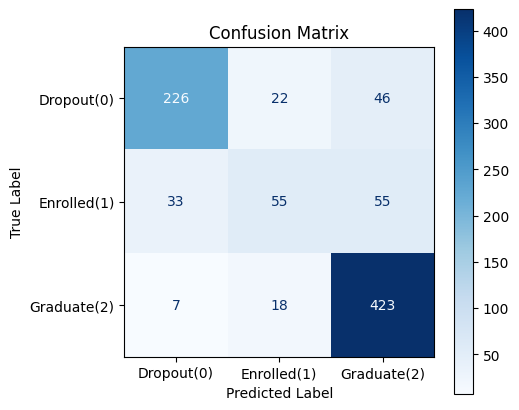

In [14]:
# Display cross-validation results
print("Cross-validation scores:", cv_scores)
print(f"Mean CV score: {cv_scores.mean():.3f}")

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate and display key performance metrics
print(f"F1 Score: {f1_score(y_test, y_pred, average=rf_settings['f1_average'])}")
print(f"Accuracy:{accuracy_score(y_test, y_pred):.3f}")

# Create and display confusion matrix to understand classification performance
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=rf_settings['confusion_matrix_labels']
)

# Plot confusion matrix with custom styling
fig,ax = plt.subplots(figsize=rf_settings['confusion_matrix_figsize'])
cm_display.plot(
    cmap=plt.cm.get_cmap(rf_settings['confusion_matrix_cmap']),
    ax=ax,
    values_format='d'
)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
plt.grid(rf_settings['grid_visible'])
plt.show()

In [15]:
# Feature importance analysis using Gini importance (built into Random Forest)
gini_importances = best_model.feature_importances_

# Create DataFrame for Gini importance and sort by importance
gini_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Gini Importance': gini_importances
})
gini_df = gini_df.sort_values(by='Gini Importance', ascending=False)

In [16]:
# Feature importance analysis using Mean Decrease in Accuracy (MDA)
# This method shuffles each feature and measures the drop in accuracy
mda_importances = []
initial_accuracy = accuracy_score(y_test, y_pred)

# For each feature, shuffle its values and measure accuracy drop
for i in range(X_data.shape[1]):
    X_test_copy = X_test.copy()
    # Shuffle the values in the specified feature column
    shuffled_column_values = X_test_copy.iloc[:, i].values.copy()
    np.random.shuffle(shuffled_column_values)
    X_test_copy.iloc[:, i] = shuffled_column_values

    # Calculate accuracy with shuffled feature
    shuff_accuracy = accuracy_score(y_test, best_model.predict(X_test_copy))
    # Importance is the drop in accuracy when feature is shuffled
    mda_importances.append(initial_accuracy - shuff_accuracy)

# Create DataFrame for MDA importance and sort by importance
mda_df = pd.DataFrame({'Feature': X_data.columns, 'Decrease in Accuracy': mda_importances}).sort_values('Decrease in Accuracy', ascending=False)

/var/folders/yf/h_vm1whn37z0ml7qr4pvqv180000gn/T/ipykernel_33649/828178592.py:15: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/joshua/Desktop/csc659/project/rf/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


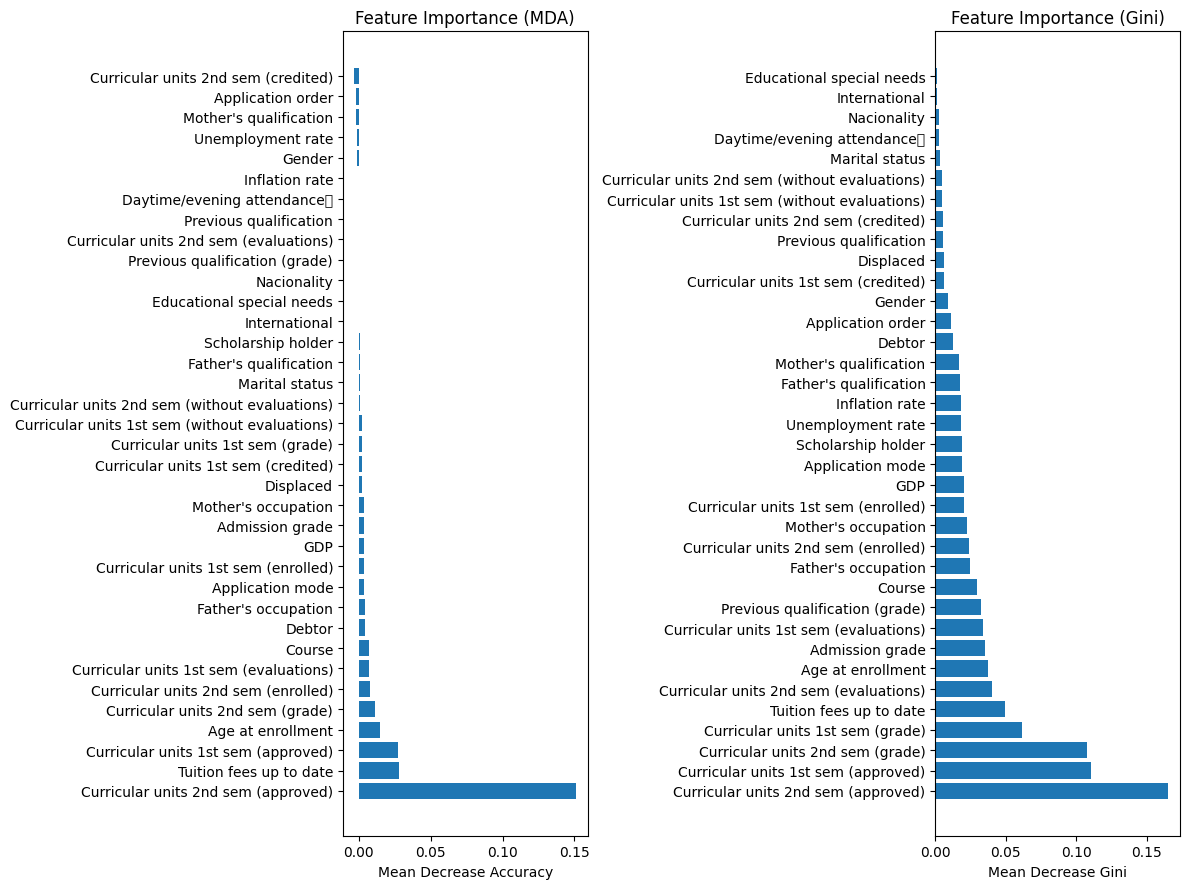

In [17]:
# Create side-by-side comparison of both feature importance methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=rf_settings['feature_importance_figsize'])

# Plot MDA feature importance
ax1.barh(mda_df['Feature'], mda_df['Decrease in Accuracy'])
ax1.set_title('Feature Importance (MDA)')
ax1.set_xlabel('Mean Decrease Accuracy')

# Plot Gini feature importance
ax2.barh(gini_df['Feature'], gini_df['Gini Importance'])
ax2.set_title('Feature Importance (Gini)')
ax2.set_xlabel('Mean Decrease Gini')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [18]:
print("Lets go Team 6!")

Lets go Team 6!
